<a href="https://colab.research.google.com/github/halujeff5/carcrash_MOD3/blob/master/TensorFlow_with_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.924809583999945
GPU (s):
0.04745946499997444
GPU speedup over CPU: 61x


In [3]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler, StandardScaler

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
#importing necessary libraries
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
pd.set_option('display.max_rows', 300)

In [6]:
df1=pd.read_csv('query (5).csv')

In [7]:
#checking the variance in my magnitude column
listA= df1['mag'] 
np.var(listA)

0.28067086505275973

In [8]:
#converting my time series from string to datetime
df1['time2']=[ele.replace('T', ' ') for ele in df1['time']]

In [9]:
#function converting string into datetime
def datetime(data):
    a=[]
    for i in range(14118):
        a.append(df1.time2[i][0:19])
    return a

In [10]:
#new variable containing my converted datetime
a=datetime(df1['time2'])

In [11]:
#passing the variable into my dataframe in a new column
df1['time3']=a

In [12]:
#examination to see cleaned data
z=df1['time3'].head(50)

In [13]:
#realized my data is backwards present to past rather than past to present so I will groupby 
#and pass agg function to get the df into the preferred order
results=df1.groupby('time3').mean()

In [14]:
#seismic 'noise'
results['no_noise_mag']= abs(results['mag']-results['mag'].mean())
results['no_noise_mag'].mean()

0.4029005020920818

In [15]:
results.reset_index()

,time3,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,no_noise_mag
0,2010-01-01 02:27:46,38.263833,-122.188167,12.705,1.62,34.0,99.0,0.027030,0.21,0.38,0.80,0.172,30.0,0.311086
1,2010-01-01 05:25:27,37.360000,-121.724000,5.670,1.00,23.0,37.0,0.037840,0.06,0.19,0.50,0.186,23.0,0.308914
2,2010-01-01 10:06:09,37.548167,-121.782167,5.451,0.92,10.0,97.0,0.076580,0.02,0.29,0.82,0.133,11.0,0.388914
3,2010-01-01 14:59:15,37.389000,-121.741000,8.260,0.83,16.0,75.0,0.027030,0.04,0.24,0.54,0.249,16.0,0.478914
4,2010-01-01 20:13:06,38.256167,-122.189333,10.272,1.18,13.0,109.0,0.032430,0.09,0.44,0.65,0.171,12.0,0.128914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14111,2020-07-30 02:51:28,37.547167,-121.932500,5.540,1.19,32.0,61.0,0.007144,0.09,0.22,0.16,0.209,22.0,0.118914
14112,2020-07-30 02:57:49,37.485167,-121.800667,8.060,1.01,24.0,72.0,0.034760,0.05,0.23,0.40,0.184,21.0,0.298914
14113,2020-07-31 19:45:52,38.124500,-122.182000,-0.020,1.40,16.0,80.0,0.025910,0.13,0.31,31.61,0.403,15.0,0.091086
14114,2020-08-02 12:40:24,37.408000,-121.755000,8.970,2.96,140.0,29.0,0.036750,0.08,0.08,0.19,0.174,65.0,1.651086


In [16]:
t= results[results['mag']<4.0]

In [17]:
s=t[t['mag']>=3.0]
s.reset_index()

,time3,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst,no_noise_mag
0,2010-01-08 19:48:50,37.482167,-121.793000,9.373,3.73,179.0,37.0,0.032430,0.15,0.14,0.33,NaN,3.0,2.421086
1,2010-03-03 20:36:33,37.417833,-121.761167,9.618,3.37,172.0,31.0,0.045050,0.15,0.12,0.29,NaN,3.0,2.061086
2,2010-03-28 06:56:32,37.478833,-121.798833,9.786,3.22,206.0,28.0,0.028830,0.17,0.13,0.34,0.171,61.0,1.911086
3,2010-05-15 17:54:42,37.700667,-122.003000,9.892,3.28,218.0,32.0,0.048650,0.16,0.11,0.17,NaN,4.0,1.971086
4,2010-05-30 06:59:57,37.718333,-122.119500,5.315,3.20,219.0,16.0,0.005405,0.17,0.09,0.14,NaN,6.0,1.891086
5,2010-06-28 14:47:04,37.742167,-122.552333,7.655,3.25,164.0,99.0,0.042340,0.09,0.11,0.16,NaN,6.0,1.941086
6,2010-07-23 21:29:10,37.665000,-122.512333,7.597,3.15,127.0,101.0,0.027030,0.10,0.16,0.20,NaN,3.0,1.841086
7,2010-09-02 16:35:33,37.961667,-122.347333,5.146,3.12,194.0,17.0,0.028830,0.18,0.10,0.20,NaN,3.0,1.811086
8,2010-10-05 13:28:23,37.398167,-121.510167,7.390,3.07,182.0,40.0,0.053150,0.13,0.11,0.28,NaN,4.0,1.761086
9,2010-10-15 16:13:53,37.410000,-121.752667,9.161,3.00,213.0,22.0,0.039640,0.13,0.09,0.20,NaN,3.0,1.691086


In [18]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(results[['mag']])
data= results.filter(['mag'])
dataset=data.values

In [19]:
dataset.shape

(14116, 1)

In [20]:
scaled_data

array([[ 0.5871766 ],
       [-0.58307827],
       [-0.7340789 ],
       ...,
       [ 0.17192488],
       [ 3.11643714],
       [-0.79070413]])

In [21]:
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

11293

In [22]:
#Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

In [23]:
train_data= scaled_data[0:training_data_len , :]

In [24]:
x_train=[]
y_train=[]

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [25]:
x_train=np.array(x_train) 
y_train=np.array(y_train)

In [26]:
# Reshape the data
x_train= np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(11233, 60, 1)

In [27]:
model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [28]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
model.fit(x_train, y_train, batch_size=7000, epochs=400)

Epoch 1/400
2/2 [==============================] - 0s 33ms/step - loss: 0.9988
Epoch 2/400
2/2 [==============================] - 0s 41ms/step - loss: 0.9913
Epoch 3/400
2/2 [==============================] - 0s 40ms/step - loss: 0.9911
Epoch 4/400
2/2 [==============================] - 0s 40ms/step - loss: 0.9904
Epoch 5/400
2/2 [==============================] - 0s 40ms/step - loss: 0.9887
Epoch 6/400
2/2 [==============================] - 0s 40ms/step - loss: 0.9878
Epoch 7/400
2/2 [==============================] - 0s 40ms/step - loss: 0.9873
Epoch 8/400
2/2 [==============================] - 0s 40ms/step - loss: 0.9867
Epoch 9/400
2/2 [==============================] - 0s 40ms/step - loss: 0.9858
Epoch 10/400
2/2 [==============================] - 0s 39ms/step - loss: 0.9850
Epoch 11/400
2/2 [==============================] - 0s 40ms/step - loss: 0.9842
Epoch 12/400
2/2 [==============================] - 0s 40ms/step - loss: 0.9832
Epoch 13/400
2/2 [==============================]

In [30]:
test_data= scaled_data[training_data_len-60: , :]
#Create teh data sets x_test and y_test
x_test=[]
y_test=dataset[training_data_len: ,:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [31]:
#Convert data into np.array
x_test = np.array(x_test)

In [32]:
#Reshape the data for keras
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] , 1))

In [33]:
x_test.shape

(2823, 60, 1)

In [34]:
#predicted magnitudes to see if there is a looming notable earthquake
predictions=model.predict(x_test)
predictions= scaler.inverse_transform(predictions)

In [35]:
#Get the RMSE
#Get the SMAPE
RMSE= np.sqrt( np.mean(predictions- y_test)**2)
RMSE


0.043254361511585855

In [36]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
print(f"SMAPE: {smape(x_test[0], predictions[0])}")


SMAPE: 114.67601806879141


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


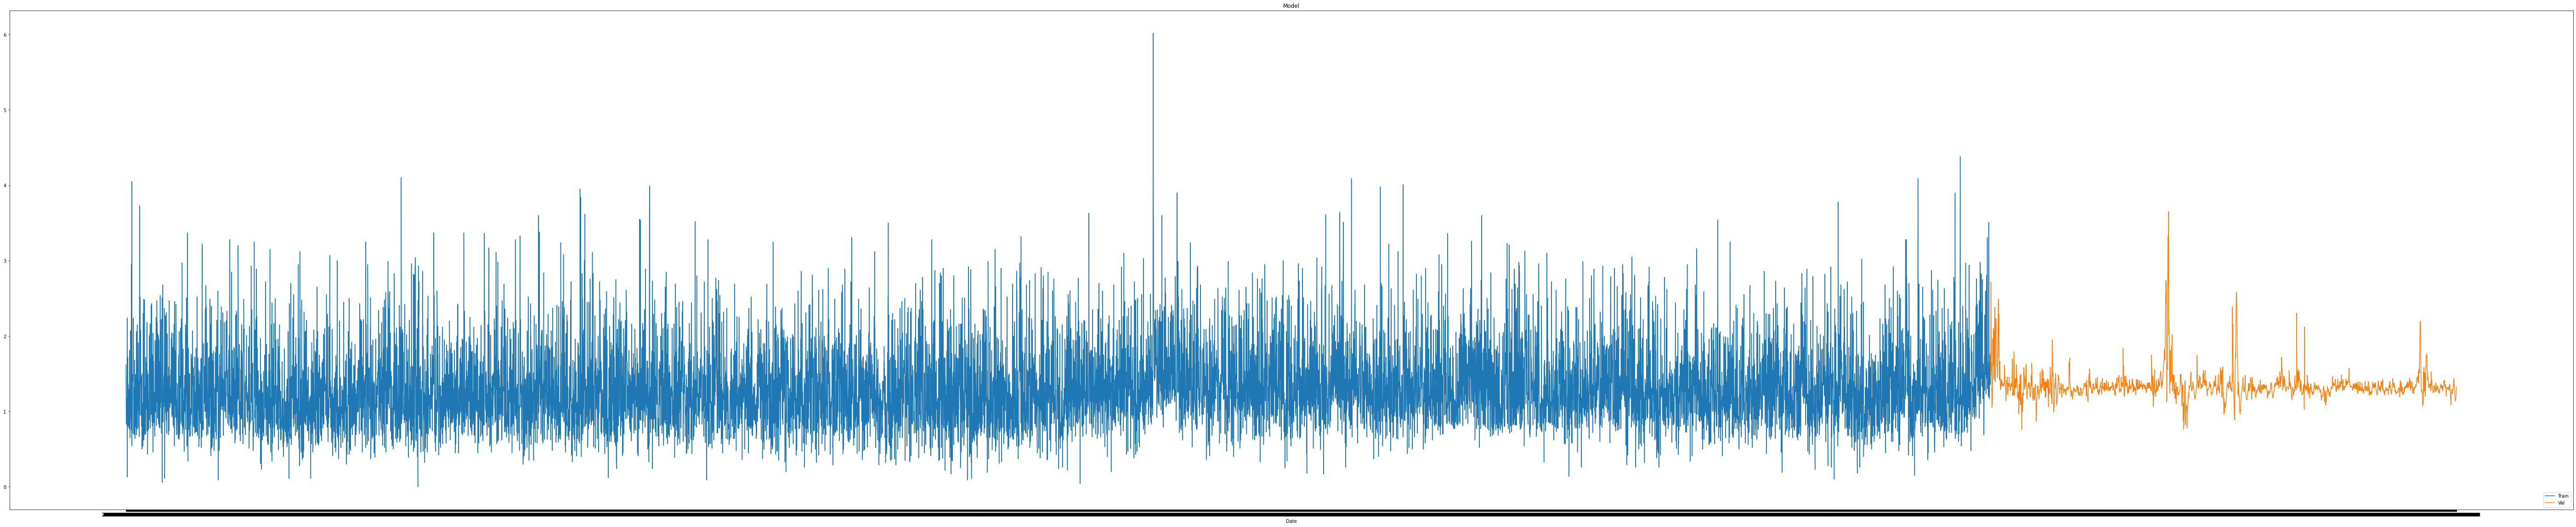

In [37]:
#Plot 
train= data[:training_data_len]
valid= data[training_data_len: ]
valid['predictions']=predictions
plt.figure(figsize=(100,20))
plt.title('Model')
plt.xlabel('Date')
plt.plot(train['mag'])
plt.plot(valid[['predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc= 'lower right')
plt.show()

In [38]:
# pip install pmdarima

In [39]:
# pip install statsmodels